# Setting

In [1]:
# !pip install datasets
# !pip install transformers

In [2]:
import os
import glob
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pickle


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.preprocessing import LabelEncoder

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision.transforms as T

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# Load Data

In [4]:
def crop(img_tensor, crop_size=32):
    C, H, W = img_tensor.shape
    img_tensor = img_tensor[:, crop_size:H-crop_size, crop_size:W-crop_size]
    return img_tensor

In [5]:
def patchify(img_tensor, patch_size=16):
    """
    img_tensor: (C, H, W) 형태 (예: (3, 224, 224))
    patch_size: 패치 크기 (16, 16)
    return: (num_patches, patch_dim)
            예) (196, 768)  # (H/16)*(W/16)=14*14=196, 768=16*16*3
    """
    C, H, W = img_tensor.shape
    assert H % patch_size == 0 and W % patch_size == 0, "이미지 크기는 patch_size로 나누어 떨어져야 함"

    # unfold로 (patch_size, patch_size)씩 잘라내기
    patches = img_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
 
    patches = patches.permute(1, 3, 0, 2, 4).contiguous()

    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    num_patches = num_patches_h * num_patches_w

    patches = patches.view(num_patches, -1) 
    return patches

def get_patch_coords(num_patches_h, num_patches_w):

    y_coord = torch.linspace(0, 1, steps=num_patches_h)
    x_coord = torch.linspace(0, 1, steps=num_patches_w)
    grid_y, grid_x = torch.meshgrid(y_coord, x_coord, indexing='ij')  # (14,14) each

    coords = torch.stack([grid_x, grid_y], dim=-1)  # (14,14,2)
    coords = coords.view(-1, 2)                     # (196, 2)
    return coords

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, crop_size=32, patch_size=16):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.label_encoder = LabelEncoder()
        self.crop_size = crop_size
        self.patch_size = patch_size

        # 데이터 및 레이블 추출
        labels = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                image_files = glob.glob(os.path.join(folder_path, "*.jpg"))
                if len(image_files) == 1:
                    image_path = image_files[0]
                else:
                    raise ValueError(f"폴더 {folder}에 JPG 파일이 하나가 아닙니다.")

                label_path = os.path.join(folder_path, "label.txt")
                if os.path.exists(label_path):
                    with open(label_path, "r") as f:
                        label = f.read().strip()
                        labels.append(label)
                        self.data.append((image_path, label))
                else:
                    raise FileNotFoundError(f"폴더 {folder}에 label.txt가 없습니다.")

        self.label_encoder.fit(labels)
        self.data = [(image_path, self.label_encoder.transform([label])[0]) 
                     for image_path, label in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)  # (3, 224, 224)
        image = crop(image, crop_size=self.crop_size)
        patches = patchify(image, patch_size=self.patch_size)  # (num_patches, patch_dim)

        H, W = image.shape[1], image.shape[2]  
        num_patches_h = H // self.patch_size   
        num_patches_w = W // self.patch_size   
        coords = get_patch_coords(num_patches_h, num_patches_w)  

        combined = torch.cat([patches, coords], dim=1)

        label = torch.tensor(label, dtype=torch.long)
        return combined, label

In [8]:
class PerceiverBlock(nn.Module):
    """
    - Cross Attention (latents -> x)
    - 이어서 Self Attention (latent들 끼리)
    - 보통은 LayerNorm, MLP(FeedForward) 등을 곁들여 residual branch를 구성
    """
    def __init__(self, latent_dim, n_heads=8, self_attn_layers=1):
        super().__init__()
        # Cross Attention
        self.cross_attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=n_heads)
        self.cross_ln = nn.LayerNorm(latent_dim)  # 잊지 말고 layernorm

        # Self Attention 여러 층
        self.self_attn_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads)
            for _ in range(self_attn_layers)
        ])

    def forward(self, latents, x):
        # latents, x: (T, B, dim) 형태로 가정 (주의!)
        # Perceiver 원리상 latents는 query, x는 key/value

        # 1) Cross Attention
        updated_latents, _ = self.cross_attn(latents, x, x)
        latents = latents + updated_latents        # Residual
        latents = self.cross_ln(latents)           # LayerNorm

        # 2) Self Attention 반복
        for layer in self.self_attn_layers:
            latents = layer(latents)  # 내부적으로 residual/LayerNorm 포함

        return latents


In [9]:
class Perceiver(nn.Module):
    def __init__(self, input_dim, latent_dim, latent_size, num_classes,
                 num_blocks, self_attn_layers_per_block=1):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.input_projection = nn.Linear(input_dim, latent_dim)

        # 반복될 PerceiverBlock을 여러 개 쌓는다.
        self.blocks = nn.ModuleList([
            PerceiverBlock(
                latent_dim=latent_dim,
                n_heads=8,
                self_attn_layers=self_attn_layers_per_block
            )
            for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        """
        x: (B, T, F) = (배치, 시퀀스길이, 피처차원)
        """
        B, T, F = x.size()
        x = self.input_projection(x)                 # (B, T, latent_dim)

        # latents: (latent_size, latent_dim) -> 배치 차원 확장 (B, latent_size, latent_dim)
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)

        # MultiHeadAttention은 (seq, batch, dim) 순서를 권장하므로 permute
        x = x.permute(1, 0, 2)        # (T, B, latent_dim)
        latents = latents.permute(1, 0, 2)  # (latent_size, B, latent_dim)

        # 여러 개의 PerceiverBlock 반복
        for block in self.blocks:
            latents = block(latents, x)

        # 최종 latents: (latent_size, B, latent_dim)
        latents = latents.permute(1, 0, 2).mean(dim=1)  # (B, latent_dim)
        return self.output_layer(latents)


In [10]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs, device):
    model.train()
    train_losses = []
    val_accuracies = []
    start = time.perf_counter()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in train_loader:
            # GPU로 옮기기
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        accuracy = evaluate_model(model, valid_loader, device=device, log_results=False)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.2f}%")
    end = time.perf_counter()
    hour = (end-start) // 3600
    min = ((end-start) % 3600) // 60
    sec = int((end-start) % 60)
    print(f"Total Train time: {hour}h {min}m {sec}s")

    return train_losses, val_accuracies


def evaluate_model(model, data_loader, device, log_results=True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        start = time.perf_counter()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        end = time.perf_counter()
        hour = (end-start) // 3600
        min = ((end-start) % 3600) // 60
        sec = (end-start) % 60
        print(f"Elapsed time on CPU: {hour}h {min}m {sec}s")

    accuracy = 100.0 * correct / total
    if log_results:
        print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [11]:
def plot_learning_curve(train_losses, val_accuracies):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Train Loss', color='tab:blue')
    ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)', color='tab:orange')
    ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.tight_layout()
    plt.title('Learning Curve')
    plt.show()

In [12]:
data_dir = '/home/youlee/n24news/n24news/image'
crop_size = 0
patch_size = 16
batch_size = 32
epochs = 20
group_class = 3

dataset = ImageDataset(root_dir=data_dir, transform=transform, crop_size=crop_size, patch_size=patch_size)
label_encoder = dataset.label_encoder
class_labels = label_encoder.classes_

class_counts = {label:0 for label in class_labels}
for _, label in dataset.data:
    class_counts[label_encoder.inverse_transform([label])[0]] += 1

target_classes = [label for label, count in class_counts.items() if count >= 2100]
for label, count in class_counts.items():
    if count>=2100:
       print(f'{label}: {count}')


Art & Design: 2431
Books: 2412
Dance: 2365
Fashion & Style: 2385
Food: 2385
Health: 2409
Media: 2363
Movies: 2384
Music: 2416
Opinion: 2437
Real Estate: 2413
Science: 2387
Sports: 2407
Style: 2147
Technology: 2376
Television: 2419
Theater: 2409
Travel: 2413


In [13]:
#random.shuffle(target_classes)
target_classes = [ # 임의로 순서지정
    "Opinion", "Art & Design", "Television",
    "Music", "Travel", "Real Estate",
    "Books", "Theater", "Health",
    "Sports", "Science", "Food",
    "Fashion & Style", "Movies", "Technology",
    "Dance", "Media", "Style"
]
target_classes

['Opinion',
 'Art & Design',
 'Television',
 'Music',
 'Travel',
 'Real Estate',
 'Books',
 'Theater',
 'Health',
 'Sports',
 'Science',
 'Food',
 'Fashion & Style',
 'Movies',
 'Technology',
 'Dance',
 'Media',
 'Style']

In [14]:
output_path = '/home/Minju/Perceiver/model'
loader_path = '/home/Minju/Perceiver/loader'

In [15]:
for i in range (0, len(target_classes), group_class):
    print(f"실험 {i//group_class + 1} 시작")
    selected_classes = target_classes[i:i+group_class]
    print(f"Selected Feature: {selected_classes}")

    filtered_data = [
        item for item in dataset.data
        if label_encoder.inverse_transform([item[1]])[0] in selected_classes
    ]

    filtered_dataset = ImageDataset(root_dir=data_dir, transform=transform, crop_size=crop_size, patch_size=patch_size)
    filtered_dataset.data = filtered_data
    filtered_dataset.label_encoder = LabelEncoder()
    filtered_dataset.label_encoder.fit(selected_classes)

    train_ratio = 0.8
    train_size = int(len(filtered_dataset) * train_ratio)
    valid_size = len(filtered_dataset) - train_size

    train_dataset, valid_dataset = random_split(filtered_dataset, [train_size, valid_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    print(f"train: {train_size}, valid: {valid_size}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    NUM_CLASSES = len(dataset.label_encoder.classes_)
    model = Perceiver(input_dim=(patch_size**2) * 3 + 2,
                        latent_dim=128, 
                        latent_size=64, 
                        num_classes=NUM_CLASSES, 
                        num_blocks=4, 
                        self_attn_layers_per_block=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    
    start = time.perf_counter()
    train_losses, val_accuracies = train_model(
        model, train_loader, valid_loader,
        criterion, optimizer, epochs,
        device=device
    )
    final_acc = evaluate_model(model, valid_loader, device=device, log_results=True)
    end = time.perf_counter()
    hour = (end-start) // 3600
    min = ((end-start) % 3600) // 60
    sec = int((end-start) % 60)
    print(f"Train time: {hour}h {min}m {sec}s")
    print(f"Final Validation Accuracy: {final_acc:.2f}%")
    print("----------------------------------------------------------")
    
    torch.save(model, f'{loader_path}/model_image_{i//3}.pkl')

    val_loader_save_path = f"{loader_path}/val_loader_{i//3}.pkl"
    with open(val_loader_save_path, 'wb') as f:
        pickle.dump(valid_dataset, f)
        

실험 1 시작
Selected Feature: ['Opinion', 'Art & Design', 'Television']
train: 5829, valid: 1458
Elapsed time on CPU: 0.0h 0.0m 8.953560227062553s
Epoch 1/20, Loss: 1.1684, Val Accuracy: 32.10%
Elapsed time on CPU: 0.0h 0.0m 8.858690312947147s
Epoch 2/20, Loss: 1.0865, Val Accuracy: 42.59%
Elapsed time on CPU: 0.0h 0.0m 8.972729098983109s
Epoch 3/20, Loss: 1.0688, Val Accuracy: 44.44%
Elapsed time on CPU: 0.0h 0.0m 8.880302579025738s
Epoch 4/20, Loss: 1.0573, Val Accuracy: 43.76%
Elapsed time on CPU: 0.0h 0.0m 9.026787247043103s
Epoch 5/20, Loss: 1.0548, Val Accuracy: 40.40%
Elapsed time on CPU: 0.0h 0.0m 8.871272169053555s
Epoch 6/20, Loss: 1.0458, Val Accuracy: 41.77%
Elapsed time on CPU: 0.0h 0.0m 8.86756345804315s
Epoch 7/20, Loss: 0.9514, Val Accuracy: 63.10%
Elapsed time on CPU: 0.0h 0.0m 8.856196803972125s
Epoch 8/20, Loss: 0.7768, Val Accuracy: 63.51%
Elapsed time on CPU: 0.0h 0.0m 8.969286703970283s
Epoch 9/20, Loss: 0.7657, Val Accuracy: 62.83%
Elapsed time on CPU: 0.0h 0.0m 8.90

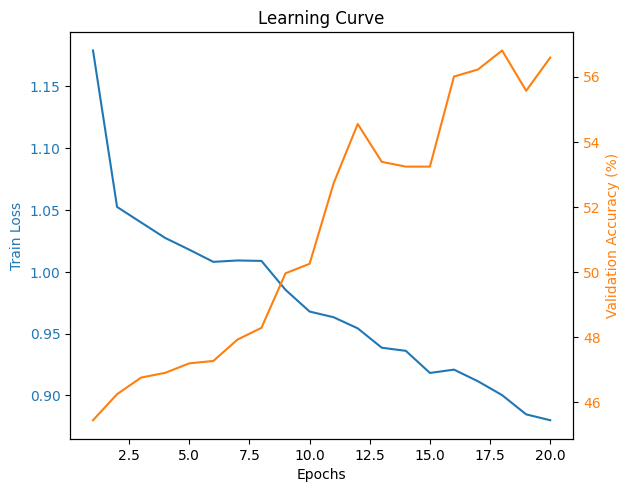

In [16]:
plot_learning_curve(train_losses, val_accuracies)

In [17]:
# mx = 0
# for i, acc in enumerate(val_accuracies):
#     if(val_accuracies[mx] < acc):
#         mx = i
# print(f'best trial: {mx+1} epoch, train loss: {train_losses[mx]}, val. acc: {val_accuracies[mx]}')